**Downloading quickdraw libraries**

# **Import libraries**

In [134]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import numpy as np
from pathlib import Path
from quickdraw import QuickDrawDataGroup
from matplotlib import pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch._C import device
from torch.utils.data import DataLoader


**Set the device**

In [135]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


**Defining the categories**

In [136]:
animals = ("bat", "bee", "cat", "duck", "elephant", "lion", "octopus", "rabbit", "snail", "whale")
image_size = (32, 32)
max_drawings = 3000

**Making the directories for each animal**

In [137]:
def download_animal(animal, image_size, max_drawings, recognized):
    
    directory = Path("data/" + animal)
    if not directory.exists():
        directory.mkdir(parents=True, exist_ok=True)

    imgs = QuickDrawDataGroup(animal, max_drawings=max_drawings, recognized=recognized)
    for img in imgs.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

In [ ]:
# uncomment this to download the images!

# for animal in animals:
#     download_animal(animal, image_size, max_drawings, recognized=True)

# **Defining dataset**

In [138]:
# create dataloaders
training_dataloader = image_dataset_from_directory(
    directory="data", 
    subset="training",
    color_mode="grayscale",
    validation_split=0.2, 
    seed=42,
    batch_size=32,
    image_size=image_size)

validation_dataloader = image_dataset_from_directory(
    directory="data",
    subset="validation",
    color_mode="grayscale",
    validation_split=0.2,
    seed=42,
    batch_size=32,
    image_size=image_size)

Found 30000 files belonging to 10 classes.
Using 24000 files for training.
Found 30000 files belonging to 10 classes.
Using 6000 files for validation.


# **Creating the model**

In [139]:
# design model
model = tf.keras.Sequential([
    Rescaling(1./255, input_shape=(32, 32, 1)), BatchNormalization(),

    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# **Compiling the model**

In [146]:
optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [144]:
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [147]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# **Training the model**

In [150]:
epochs = 25

model.fit(training_dataloader, validation_data = validation_dataloader, epochs = epochs)

model.save("./models/final_model")

Epoch 1/25
750/750 [==============================] - 61s 82ms/step - loss: 2.0504 - accuracy: 0.3084 - val_loss: 1.7332 - val_accuracy: 0.4443
Epoch 2/25
750/750 [==============================] - 71s 94ms/step - loss: 1.6139 - accuracy: 0.4725 - val_loss: 1.4143 - val_accuracy: 0.5603
Epoch 3/25
750/750 [==============================] - 63s 84ms/step - loss: 1.3811 - accuracy: 0.5570 - val_loss: 1.2228 - val_accuracy: 0.6192
Epoch 4/25
750/750 [==============================] - 60s 80ms/step - loss: 1.2282 - accuracy: 0.6050 - val_loss: 1.1091 - val_accuracy: 0.6563
Epoch 5/25
750/750 [==============================] - 61s 82ms/step - loss: 1.1096 - accuracy: 0.6504 - val_loss: 0.9996 - val_accuracy: 0.6930
Epoch 6/25
750/750 [==============================] - 60s 81ms/step - loss: 0.9953 - accuracy: 0.6883 - val_loss: 0.9010 - val_accuracy: 0.7260
Epoch 7/25
750/750 [==============================] - 62s 82ms/step - loss: 0.8982 - accuracy: 0.7188 - val_loss: 0.8319 - val_accuracy:

INFO:tensorflow:Assets written to: ./models/final_model/assets


# **Testing accuracy**

In [151]:
test_loss, test_acc = model.evaluate(validation_dataloader, verbose=2)

188/188 - 4s - loss: 0.5418 - accuracy: 0.8355 - 4s/epoch - 19ms/step


**Input a random image**

In [12]:
# load in model
loaded_model = tf.keras.models.load_model("./models/test_model")

1/1 [==============================] - 0s 16ms/step
This doodle is of a ~ bat ~!


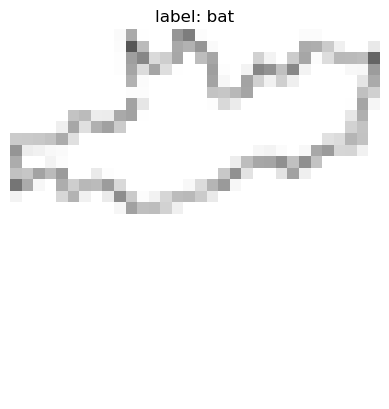

In [163]:
for images, labels in training_dataloader.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
  
image_data = numpy_images[0].astype("uint8")
label_data = numpy_labels[0]
plt.axis("off")
plt.title("label: " + training_dataloader.class_names[label_data])
plt.imshow(image_data, cmap='gray', vmin=0, vmax=255)

reshaped_image = np.resize(image_data,(1, 32, 32, 1))
test_predictions = loaded_model.predict(reshaped_image)
result_index = np.argmax(test_predictions)
result_label = training_dataloader.class_names[result_index]
print(f"This doodle is of a ~ {result_label} ~!")
